<a href="https://colab.research.google.com/github/hissain/ml/blob/main/advance/RL_Policy_gradient_actor_critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this in Colab. Installs and imports.
!pip install gymnasium box2d-py >/dev/null 2>&1 || true
!pip install gymnasium[box2d] >/dev/null 2>&1 || true
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu >/dev/null 2>&1 || true
!pip install matplotlib numpy pandas >/dev/null 2>&1 || true

import math
import random
import time
from collections import defaultdict, deque

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim

# set seed for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print('Setup complete')

Setup complete


Define two reward shaping functions

In [ ]:
# 1) Identity (no shaping)
def identity_shaper(s, a, s2, r):
    return r

# 2) Dense shaping: small negative step penalty, big positive for goal

def dense_shaper(s, a, s2, r):
    # environment gives r=1 on reaching goal, 0 otherwise
    # give small -0.01 per step to encourage shorter paths
    step_penalty = -0.01
    return r + step_penalty

Train and compare

In [ ]:
# Install the necessary dependency to render the environment for video generation
!pip install gymnasium[box2d] >/dev/null 2>&1 || true
import moviepy.editor as mp
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
# Function to save frames and create a video
def generate_video(env, policy, filename="cartpole.mp4", episodes=1):


    frames = []
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        while not done:
            frame = env.render()
            frames.append(frame)
            s_v = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
            probs = policy(s_v).detach().numpy()[0]
            a = np.random.choice(len(probs), p=probs) # Use random sampling based on probability
            s, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

    env.close() # Close the environment after rendering

    if frames:
        clip = ImageSequenceClip(frames, fps=30) # 30 fps
        clip.write_videofile(filename, fps=30)
        print(f"Video saved as {filename}")
    else:
        print("No frames captured to create video.")

# Example usage after training:
# Assuming 'policy' is your trained policy network for CartPole
# generate_video(gym.make('CartPole-v1', render_mode='rgb_array'), policy, episodes=1)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



# 🎯 3 — Policy Gradient (REINFORCE) with Custom Rewards on CartPole

**CartPole** is a classic control problem in reinforcement learning.  
The agent must balance a pole on a moving cart by applying forces (left or right).  
The environment has a **continuous state space** and **discrete action space**.

We’ll implement a **PyTorch policy gradient agent** using the **REINFORCE algorithm**,  
optionally enhanced with a **baseline (value network)** for variance reduction.

---

## ⚙️ 3.1 — Environment and Helper Functions

```python
env = gym.make('CartPole-v1')

obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

print('obs_dim:', obs_dim, ' | n_actions:', n_actions)


---

## 💬 Discussion

Observe how **reward shaping** influences learning behavior:

- On **deterministic FrozenLake**, shaping that **penalizes extra steps** encourages the agent to find **shorter, more direct paths** to the goal.  
- Proper shaping can **accelerate convergence**, but overly strong penalties may cause **risky or unstable exploration**.  
- Always balance shaping strength with task complexity — shaping should *guide*, not *dictate* the policy.

---

# 🎯 3 — Policy Gradient (REINFORCE) with Custom Rewards on CartPole

**CartPole** is a classic control task in reinforcement learning.  
The agent must balance a pole on a moving cart by applying forces left or right.

- **State space:** continuous (cart position, velocity, pole angle, angular velocity)  
- **Action space:** discrete (`0 = left`, `1 = right`)  
- **Goal:** keep the pole upright for as long as possible.

We’ll implement a **PyTorch policy network** trained using the **REINFORCE algorithm**,  
optionally enhanced with a **value network (baseline)** to reduce variance.

---

## ⚙️ 3.1 — Environment and Helper Setup

```python
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

env = gym.make('CartPole-v1')

obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

print('obs_dim:', obs_dim, '| n_actions:', n_actions)


In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions),
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

---

# 🧭 Understanding Policy Gradient and REINFORCE

## 🎯 Intuition

In **policy gradient methods**, we directly optimize the parameters of a **stochastic policy**  
(usually a neural network) that maps states → action probabilities.

Instead of learning a value function (like Q-learning), the agent **learns to act** by adjusting  
its policy parameters in the direction that **increases expected reward**.

---

## 🧮 The Objective

Let the policy be parameterized by θ (theta):

πθ(a | s) = Probability of taking action a in state s under parameters θ

Goal: maximize the expected discounted return

J(θ) = Eπθ [ Σ (γ^t * R_t) ]

where:
- R_t is the reward at time t  
- γ (gamma) is the discount factor between 0 and 1  

---

## 📈 The Policy Gradient Theorem

The gradient of this objective (how we adjust θ) is:

∇θ J(θ) = Eπθ [ ∇θ log πθ(a_t | s_t) * G_t ]

where:
- ∇θ log πθ(a_t | s_t) measures how strongly the chosen action depends on θ  
- G_t is the discounted return from time t (G_t = R_t + γR_{t+1} + γ²R_{t+2} + ...)

**Meaning:**  
Increase the probability of actions that led to **higher returns**,  
and decrease it for actions that performed poorly.

---

## 🧠 REINFORCE Algorithm (Williams, 1992)

REINFORCE is the simplest Monte Carlo policy gradient method.

**Steps:**
1. Run the current policy πθ to collect one full episode of (state, action, reward) data.  
2. Compute returns for each step:  
   G_t = R_t + γR_{t+1} + γ²R_{t+2} + ...  
3. Compute the policy loss:  
   L(θ) = -Σ [ log πθ(a_t | s_t) * G_t ]  
4. Update parameters with gradient descent:  
   θ ← θ - α * ∇θ L(θ)

---

## ⚙️ Practical Notes

- Monte Carlo approach: uses **complete episodes** (no bootstrapping).  
- Can have **high variance** since returns vary by episode.  
- Adding a **baseline** (e.g., a value function) can reduce variance without adding bias.  
- **Exploration** happens naturally because the policy is stochastic.  

---

## 🧩 Comparison with Value-Based Methods

| Aspect | Policy Gradient (REINFORCE) | Value-Based (Q-learning) |
|:--|:--|:--|
| Output | Probability distribution over actions | Q-values (expected return per action) |
| Exploration | Inherent (sampling from policy) | Usually ε-greedy or noise-based |
| Suitable for | Continuous or stochastic policies | Discrete, deterministic problems |
| Variance | Higher | Lower |
| Convergence | Stable but slower | Often faster, less stable |

---

✅ **Summary:**
- Policy gradients directly **optimize the policy behavior**, not the value function.  
- REINFORCE provides the foundation for modern **Actor-Critic** algorithms.  
- Key idea:  
  **Reward good actions by increasing their probability, and penalize bad ones.**

---


# 3.3 — Custom reward shaping examples for CartPole
We will provide two versions:
- default_shaper: uses environment reward (1 per timestep)
- angle_shaper: gives extra positive reward when pole angle is near zero (encourage balance) and small penalty for large cart position (keep near center)

In [ ]:
def default_shaper(state, action, reward):
    return reward

def angle_shaper(state, action, reward):
    # state: [x, x_dot, theta, theta_dot]
    x, xdot, theta, thetadot = state
    angle_bonus = math.exp(-abs(theta)*10)  # near-zero angle -> bonus ~1
    center_penalty = -abs(x) * 0.01
    return reward + angle_bonus + center_penalty

3.4 — REINFORCE implementation (with optional baseline/value network)

3.5 — Train agents with/without shaping and with/without baseline

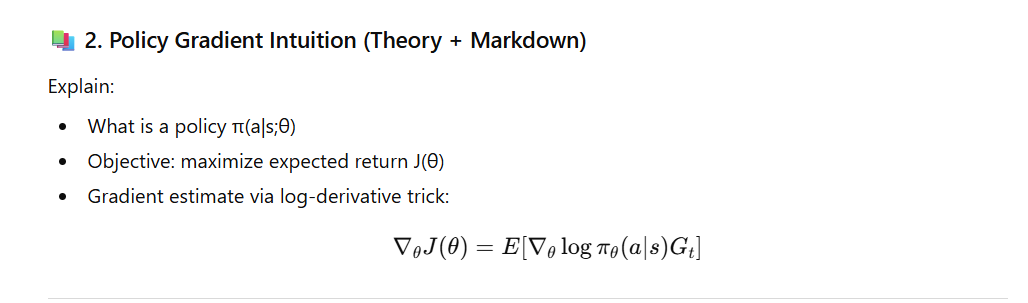

# Full Actor-Critic Model --> Actor (Policy), Critic (Value)

In [ ]:
# Policy and Value Network Definitions moved here for self-containment
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions),
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# Custom reward shaping examples for CartPole moved here for self-containment
def default_shaper(state, action, reward):
    return reward

def angle_shaper(state, action, reward):
    # state: [x, x_dot, theta, theta_dot]
    x, xdot, theta, thetadot = state
    angle_bonus = math.exp(-abs(theta)*10)  # near-zero angle -> bonus ~1
    center_penalty = -abs(x) * 0.01
    return reward + angle_bonus + center_penalty

# REINFORCE implementation (with optional baseline/value network) moved here for self-containment
def reinforce(env, policy_net, value_net=None, num_episodes=500, gamma=0.99, lr=1e-3, reward_shaper=None, baseline=False):
    optimizer_policy = optim.Adam(policy_net.parameters(), lr=lr)
    if baseline and value_net is not None:
        optimizer_value = optim.Adam(value_net.parameters(), lr=lr)

    episode_rewards = []
    for ep in range(num_episodes):
        states = []
        actions = []
        rewards = []

        s, _ = env.reset(seed=SEED+ep)
        done = False
        t = 0
        while not done and t < 1000:
            state_v = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
            probs = policy_net(state_v).detach().numpy()[0]
            a = np.random.choice(len(probs), p=probs)

            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            if reward_shaper:
                r = reward_shaper(s, a, r)

            states.append(s)
            actions.append(a)
            rewards.append(r)
            s = s2
            t += 1

        # compute returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)

        # normalize returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # policy loss
        policy_loss = 0
        for st, a, Gt in zip(states, actions, returns):
            st_v = torch.tensor(st, dtype=torch.float32).unsqueeze(0)
            probs = policy_net(st_v)
            logp = torch.log(probs[0, a] + 1e-8)

            if baseline and value_net is not None:
                baseline_v = value_net(st_v).detach()
                advantage = Gt - baseline_v
                policy_loss -= logp * advantage
            else:
                policy_loss -= logp * Gt

        optimizer_policy.zero_grad()
        policy_loss.backward()
        optimizer_policy.step()

        # value (baseline) update
        if baseline and value_net is not None:
            optimizer_value.zero_grad()
            # Modified to ensure gradients are tracked for value loss
            vals = torch.stack([value_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0)) for s in states]).squeeze(-1)
            value_loss = nn.MSELoss()(vals, returns)
            value_loss.backward()
            optimizer_value.step()

        episode_rewards.append(sum(rewards))

    return episode_rewards


obs_dim 4 n_actions 2
obs_space:  Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action_space:  Discrete(2)
Training REINFORCE baseline=False, default reward...
Training REINFORCE baseline=True, angle shaping...


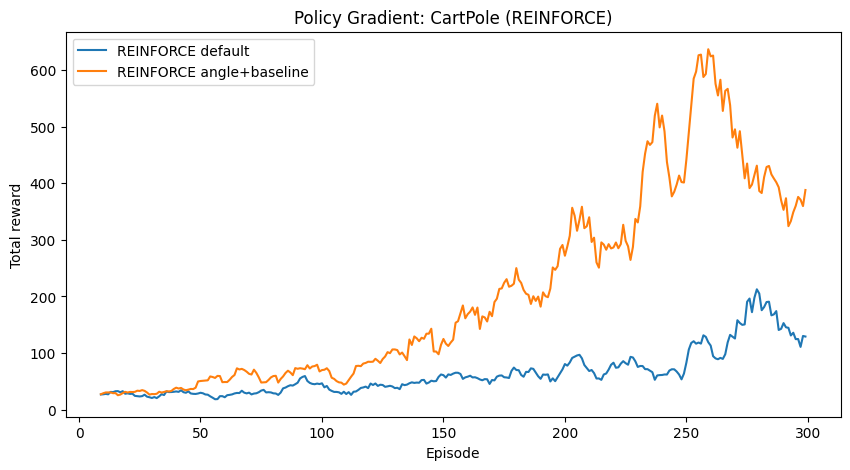

Moviepy - Building video cartpole.mp4.
Moviepy - Writing video cartpole.mp4



Moviepy - Done !
Moviepy - video ready cartpole.mp4
Video saved as cartpole.mp4


In [ ]:
# Environment setup moved here for self-containment
env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
print('obs_dim', obs_dim, 'n_actions', n_actions)
print('obs_space: ', env.observation_space)
print('action_space: ', env.action_space)



# instantiate networks
policy = PolicyNet(obs_dim, n_actions)
value = ValueNet(obs_dim)

print('Training REINFORCE baseline=False, default reward...')
rew_default = reinforce(env, policy, value_net=None, num_episodes=300, gamma=0.99, lr=1e-3, reward_shaper=default_shaper, baseline=False)

# Reset network weights for fair comparison
policy = PolicyNet(obs_dim, n_actions)
value = ValueNet(obs_dim)
print('Training REINFORCE baseline=True, angle shaping...')
rew_angle_baseline = reinforce(env, policy, value_net=value, num_episodes=300, gamma=0.99, lr=1e-3, reward_shaper=angle_shaper, baseline=True)

plt.figure(figsize=(10,5))
plt.plot(pd.Series(rew_default).rolling(10).mean(), label='REINFORCE default')
plt.plot(pd.Series(rew_angle_baseline).rolling(10).mean(), label='REINFORCE angle+baseline')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.legend()
plt.title('Policy Gradient: CartPole (REINFORCE)')
plt.show()

# Generate video after training the policy


In [ ]:
generate_video(gym.make('CartPole-v1', render_mode='rgb_array'), policy, episodes=1)

In [ ]:
# small utility to run a trained policy

def run_policy(env, policy, episodes=5):
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0
        while not done:
            s_v = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
            probs = policy(s_v).detach().numpy()[0]
            a = np.argmax(probs)
            s, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            total += r
        print('Episode', ep, 'reward', total)

# 🚀  Implement REINFORCE (Monte Carlo Policy Gradient)

In [ ]:
!pip install gymnasium torch matplotlib --quiet

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Categorical


In [ ]:
class CustomCartPole(gym.Wrapper):
    def __init__(self):
        super().__init__(gym.make('CartPole-v1', render_mode='rgb_array'))

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        # reward shaping: penalize pole angle and cart velocity
        x, x_dot, theta, theta_dot = state
        reward -= 0.1 * abs(x_dot) + 0.5 * abs(theta_dot)
        return state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

custom_env = CustomCartPole()


In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.net(x)

def reinforce_train( env=None, n_episodes=1000, gamma=0.99 ):
    # env = gym.make(env_name)
    policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    returns = []

    for episode in range(n_episodes):
        log_probs, rewards = [], []
        state, _ = env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state)
            probs = policy(state_tensor)
            dist = Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            # if terminated:
            #     reward = -10
            # if truncated:
            #     reward = 100

            rewards.append(reward)
            state = next_state

        # compute discounted returns
        discounted_returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            discounted_returns.insert(0, G)
        discounted_returns = torch.tensor(discounted_returns)
        discounted_returns = (discounted_returns - discounted_returns.mean()) / (discounted_returns.std() + 1e-8)

        # update policy
        loss = -torch.sum(torch.stack(log_probs) * discounted_returns)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        returns.append(sum(rewards))
        if (episode+1) % 50 == 0:
            print(f"Episode {episode+1}, Return: {np.mean(returns[-50:])}")

    plt.plot(returns)
    plt.title("REINFORCE Training Returns")
    plt.show()
    return returns, policy



Episode 50, Return: 43.658016204833984
Episode 100, Return: 64.86995697021484
Episode 150, Return: 189.74217224121094
Episode 200, Return: 399.9096984863281
Episode 250, Return: 198.90089416503906
Episode 300, Return: 341.6734619140625
Episode 350, Return: 170.8081817626953
Episode 400, Return: 106.37837982177734
Episode 450, Return: 43.18913650512695
Episode 500, Return: 83.72024536132812


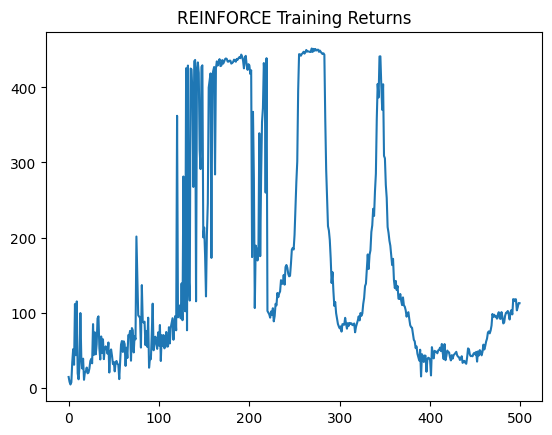

In [ ]:
returns, policy = reinforce_train(env = custom_env, n_episodes=500, gamma=0.99)


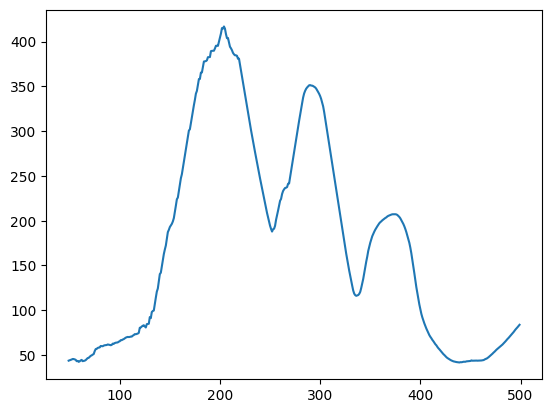

In [ ]:
plt.plot(pd.Series(returns).rolling(50).mean(), label='Policy Gradient')


In [ ]:
# Install the necessary dependency to render the environment for video generation
!pip install gymnasium[box2d] >/dev/null 2>&1 || true
import moviepy.editor as mp
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
# Function to save frames and create a video
def generate_video(env, policy, filename="cartpole.mp4", episodes=1):


    frames = []
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        while not done:

            s_v = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
            probs = policy(s_v).detach().numpy()[0]
            a = np.random.choice(len(probs), p=probs) # Use random sampling based on probability
            s, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            frame = env.render()
            frames.append(frame)

    env.close() # Close the environment after rendering

    if frames:
        clip = ImageSequenceClip(frames, fps=30) # 30 fps
        clip.write_videofile(filename, fps=30)
        print(f"Video saved as {filename}")
    else:
        print("No frames captured to create video.")

# Example usage after training:
# Assuming 'policy' is your trained policy network for CartPole
# generate_video(gym.make('CartPole-v1', render_mode='rgb_array'), policy, episodes=3)
generate_video(CustomCartPole(), policy, episodes=3)

Moviepy - Building video cartpole.mp4.
Moviepy - Writing video cartpole.mp4



Moviepy - Done !
Moviepy - video ready cartpole.mp4
Video saved as cartpole.mp4


## Custom Reward Shaping & State Representation

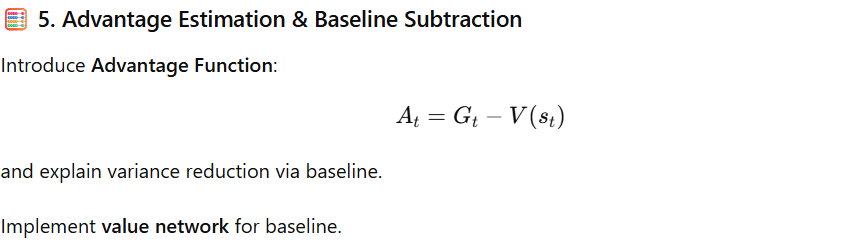

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
def reinforce_with_baseline(env_name="CartPole-v1", n_episodes=1000, gamma=0.99):
    env = gym.make(env_name)
    policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    value = ValueNetwork(env.observation_space.shape[0])
    policy_optim = optim.Adam(policy.parameters(), lr=0.001)
    value_optim = optim.Adam(value.parameters(), lr=0.005)

    all_returns = []
    for ep in range(n_episodes):
        log_probs, rewards, states = [], [], []
        state, _ = env.reset()
        done = False
        while not done:
            s_tensor = torch.FloatTensor(state)
            probs = policy(s_tensor)
            dist = Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            states.append(s_tensor)
            next_state, reward, term, trunc, _ = env.step(action.item())
            done = term or trunc
            rewards.append(reward)
            state = next_state

        # compute returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)

        # compute advantages
        values = torch.cat([value(s.unsqueeze(0)) for s in states]).squeeze()
        advantages = returns - values.detach()

        # update policy
        policy_loss = -torch.sum(torch.stack(log_probs) * advantages)
        policy_optim.zero_grad()
        policy_loss.backward()
        policy_optim.step()

        # update value function
        value_loss = nn.MSELoss()(values, returns)
        value_optim.zero_grad()
        value_loss.backward()
        value_optim.step()

        all_returns.append(sum(rewards))
        if (ep+1) % 50 == 0:
            print(f"Episode {ep+1}, Return: {np.mean(all_returns[-50:]):.2f}")

    plt.plot(all_returns)
    plt.title("REINFORCE with Baseline (Advantage Estimation)")
    plt.show()



In [ ]:
reinforce_with_baseline()


## 🤖  Full Actor-Critic Implementation (A2C)

In [ ]:
def actor_critic_train(env_name="CartPole-v1", n_episodes=500, gamma=0.99):
    env = gym.make(env_name)
    policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    value = ValueNetwork(env.observation_space.shape[0])
    optim_policy = optim.Adam(policy.parameters(), lr=1e-3)
    optim_value = optim.Adam(value.parameters(), lr=5e-3)
    returns = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        ep_return = 0

        while not done:
            s_tensor = torch.FloatTensor(state)
            probs = policy(s_tensor)
            dist = Categorical(probs)
            action = dist.sample()
            next_state, reward, term, trunc, _ = env.step(action.item())
            done = term or trunc
            ep_return += reward

            # Compute TD target and advantage
            with torch.no_grad():
                V_next = value(torch.FloatTensor(next_state))
                td_target = reward + gamma * V_next * (1 - done)
            V = value(s_tensor)
            advantage = td_target - V

            # update policy and value
            policy_loss = -dist.log_prob(action) * advantage.detach()
            value_loss = advantage.pow(2)

            optim_policy.zero_grad()
            policy_loss.backward()
            optim_policy.step()

            optim_value.zero_grad()
            value_loss.backward()
            optim_value.step()

            state = next_state

        returns.append(ep_return)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}, Avg Return: {np.mean(returns[-50:]):.2f}")

    plt.plot(returns)
    plt.title("Actor-Critic Training Returns (A2C)")
    plt.show()

actor_critic_train()


# Continous Actions-Space

In [ ]:
env = gym.make('MountainCarContinuous-v0')
print("Environment created:", env.spec.id)
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Environment created: MountainCarContinuous-v0
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Box(-1.0, 1.0, (1,), float32)


In [ ]:
# Gaussian policy network for continuous actions
import torch
import torch.nn as nn

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
        )
        self.mean = nn.Linear(128, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        h = self.base(x)
        mean = self.mean(h)
        std = torch.exp(self.log_std)
        return mean, std

# Gaussian log-prob function
import math

def gaussian_log_prob(mean, std, action):
    var = std.pow(2)
    log_scale = std.log()
    return -0.5 * (((action - mean)**2) / var + 2*log_scale + math.log(2*math.pi)).sum(dim=-1)